# Data Preprocessing



In [ ]:
# Install necessary packages
!pip install numpy pandas librosa matplotlib scikit-learn tensorflow pickle-mixin

  Preparing metadata (setup.py) ... done
  Created wheel for pickle-mixin: filename=pickle_mixin-1.0.2-py3-none-any.whl size=5990 sha256=7071e77f66e0f04ab378b03c7a5dee23869c7ae0fe2ab4cc018bfb076c0726ea
  Stored in directory: /root/.cache/pip/wheels/3e/c6/e9/d1b0a34e1efc6c3ec9c086623972c6de6317faddb2af0a619c
Successfully built pickle-mixin


In [ ]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
from scipy.io import wavfile
from scipy.signal import resample
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import librosa

In [ ]:
!git clone https://github.com/nursyaziah/SpeechToEmotions_Grp3.git

Cloning into 'SpeechToEmotions_Grp3'...
remote: Enumerating objects: 12293, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 12293 (delta 10), reused 31 (delta 8), pack-reused 12252 (from 1)
Receiving objects: 100% (12293/12293), 985.12 MiB | 30.09 MiB/s, done.
Resolving deltas: 100% (282/282), done.
Updating files: 100% (22739/22739), done.


In [ ]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# Define the correct path to the CSV file
csv_file_path = os.path.join('/content/SpeechToEmotions_Grp3', 'audio_dataset_info.csv')

# Load your dataset
data = pd.read_csv(csv_file_path)  # Use the defined path

# Ensure the necessary columns exist in the dataset
assert 'emotion' in data.columns, "The dataset must have an 'emotion' column."
assert 'intensity' in data.columns, "The dataset must have an 'intensity' column."
assert 'gender' in data.columns, "The dataset must have a 'gender' column."
assert 'path' in data.columns, "The dataset must have a 'path' column."

# Ensure unique paths
assert data['path'].is_unique, "The 'path' column must have unique values for each audio file."

# Group data by path to ensure unique audio files across splits
path_groups = data.groupby('path')
paths = list(path_groups.groups.keys())

# Split paths into train (70%), validation (15%), and test (15%)
train_paths, temp_paths = train_test_split(paths, test_size=0.3, random_state=42, stratify=data['emotion'])

# Filter the data based on temp_paths to get temp_data
temp_data = data[data['path'].isin(temp_paths)]

# Now split temp_data into validation and test sets
val_paths, test_paths = train_test_split(temp_data['path'], test_size=0.5, random_state=42, stratify=temp_data['emotion'])

# Function to filter data by paths
def filter_data_by_paths(df, paths):
    return df[df['path'].isin(paths)]

# Create train, validation, and test splits
train_data = filter_data_by_paths(data, train_paths)
val_data = filter_data_by_paths(data, val_paths)
test_data = filter_data_by_paths(data, test_paths)

# Ensure emotion balance in each split
def check_emotion_balance(df, split_name):
    emotion_counts = df['emotion'].value_counts(normalize=True)
    print(f"Emotion distribution in {split_name} set:\n{emotion_counts}\n")

check_emotion_balance(train_data, "train")
check_emotion_balance(val_data, "validation")
check_emotion_balance(test_data, "test")

# Ensure gender distribution in each split
def check_gender_distribution(df, split_name):
    gender_counts = df['gender'].value_counts(normalize=True)
    print(f"Gender distribution in {split_name} set:\n{gender_counts}\n")

check_gender_distribution(train_data, "train")
check_gender_distribution(val_data, "validation")
check_gender_distribution(test_data, "test")

# Ensure intensity distribution in each split
def check_intensity_distribution(df, split_name):
    intensity_distribution = df['intensity'].value_counts(normalize=True)
    print(f"Intensity distribution in {split_name} set:\n{intensity_distribution}\n")

check_intensity_distribution(train_data, "train")
check_intensity_distribution(val_data, "validation")
check_intensity_distribution(test_data, "test")

# Save splits for future use
train_data.to_csv(os.path.join('/content/SpeechToEmotions_Grp3', 'train_data.csv'), index=False)
val_data.to_csv(os.path.join('/content/SpeechToEmotions_Grp3', 'val_data.csv'), index=False)
test_data.to_csv(os.path.join('/content/SpeechToEmotions_Grp3', 'test_data.csv'), index=False)

print("Data splits created and saved successfully.")


Emotion distribution in train set:
emotion
happy      0.176455
neutral    0.172395
angry      0.172124
disgust    0.171313
sad        0.155345
fear       0.152368
Name: proportion, dtype: float64

Emotion distribution in validation set:
emotion
disgust    0.178662
angry      0.176768
happy      0.166667
neutral    0.165404
fear       0.159722
sad        0.152778
Name: proportion, dtype: float64

Emotion distribution in test set:
emotion
disgust    0.178662
angry      0.176768
happy      0.166667
neutral    0.166035
fear       0.159722
sad        0.152146
Name: proportion, dtype: float64

Gender distribution in train set:
gender
F    0.558863
M    0.441137
Name: proportion, dtype: float64

Gender distribution in validation set:
gender
F    0.565025
M    0.434975
Name: proportion, dtype: float64

Gender distribution in test set:
gender
F    0.535354
M    0.464646
Name: proportion, dtype: float64

Intensity distribution in train set:
intensity
unspecified    0.577808
normal         0.3254

In [ ]:
import os
import shutil
import pandas as pd

# Load train, val, and test CSVs with the correct path
train_csv = pd.read_csv(os.path.join('/content/SpeechToEmotions_Grp3', 'train_data.csv'))  # Specify the full path
val_csv = pd.read_csv(os.path.join('/content/SpeechToEmotions_Grp3', 'val_data.csv'))  # Specify the full path
test_csv = pd.read_csv(os.path.join('/content/SpeechToEmotions_Grp3', 'test_data.csv'))  # Specify the full path

# Create directories for train, val, and test datasets
os.makedirs("train", exist_ok=True)
os.makedirs("val", exist_ok=True)
os.makedirs("test", exist_ok=True)

# Function to copy files
def copy_files(csv_data, destination_folder):
    dataset_root = "/content/SpeechToEmotions_Grp3/"

    for index, row in csv_data.iterrows():
        file_path = os.path.join(dataset_root, row['path'].lstrip("./"))  # Remove leading "./" from relative paths

        # Ensure the file exists before copying
        if os.path.exists(file_path):
            try:
                # Preserve the directory structure in the destination folder (optional)
                emotion_folder = os.path.join(destination_folder, row['emotion'])  # Organize by emotion subfolder
                os.makedirs(emotion_folder, exist_ok=True)  # Create emotion subfolder if it doesn't exist
                shutil.copy(file_path, emotion_folder)
                print(f"Copied: {file_path} to {emotion_folder}")
            except Exception as e:
                print(f"Error copying file {file_path}: {e}")
        else:
            print(f"File not found: {file_path}")

# Copy files to respective folders
print("Copying train files...")
copy_files(train_csv, "train")
print("Copying validation files...")
copy_files(val_csv, "val")
print("Copying test files...")
copy_files(test_csv, "test")

print("Files successfully copied!")


Streaming output truncated to the last 5000 lines.
Copied: /content/SpeechToEmotions_Grp3/standardised_datasets/CREMA/01_03_M_crema_1048_IEO.wav to train/neutral
Copied: /content/SpeechToEmotions_Grp3/standardised_datasets/CREMA/03_02_F_crema_1054_IEO.wav to train/happy
Copied: /content/SpeechToEmotions_Grp3/standardised_datasets/CREMA/05_03_M_crema_1070_ITH.wav to train/angry
Copied: /content/SpeechToEmotions_Grp3/standardised_datasets/CREMA/06_03_M_crema_1026_WSI.wav to train/fear
Copied: /content/SpeechToEmotions_Grp3/standardised_datasets/CREMA/06_03_M_crema_1051_ITS.wav to train/fear
Copied: /content/SpeechToEmotions_Grp3/standardised_datasets/CREMA/04_03_F_crema_1029_WSI.wav to train/sad
Copied: /content/SpeechToEmotions_Grp3/standardised_datasets/CREMA/04_03_F_crema_1028_IWW.wav to train/sad
Copied: /content/SpeechToEmotions_Grp3/standardised_datasets/CREMA/07_03_F_crema_1009_IWL.wav to train/disgust
Copied: /content/SpeechToEmotions_Grp3/standardised_datasets/CREMA/06_03_F_crem

Emotion Counts:
 emotion
happy      1832
angry      1832
disgust    1832
neutral    1799
fear       1632
sad        1631
Name: count, dtype: int64


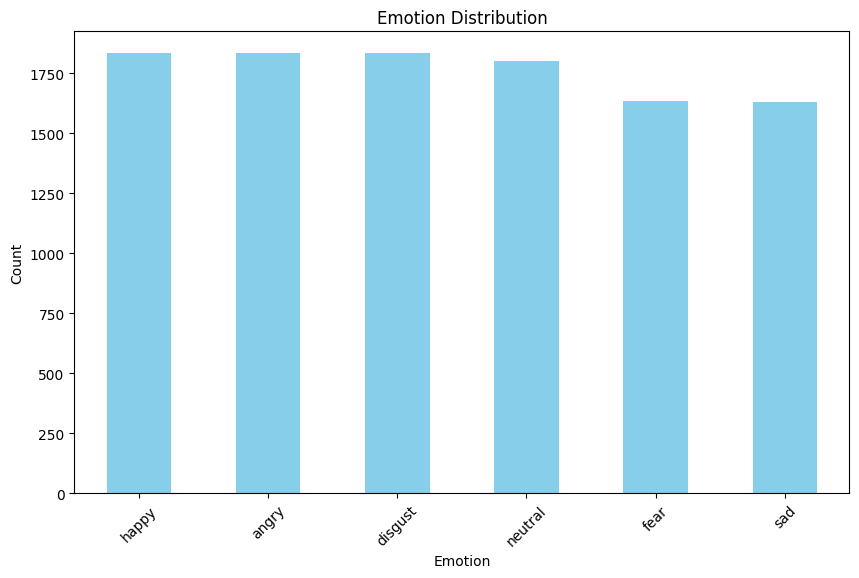

Intensity Counts:
 intensity
unspecified    6076
normal         3451
strong         1031
Name: count, dtype: int64


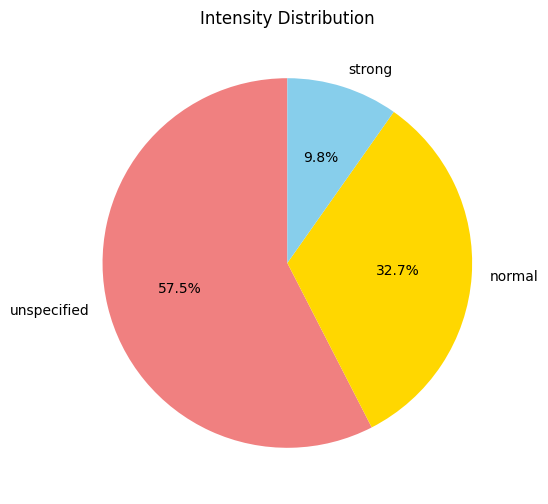

Gender Counts:
 gender
F    5873
M    4685
Name: count, dtype: int64


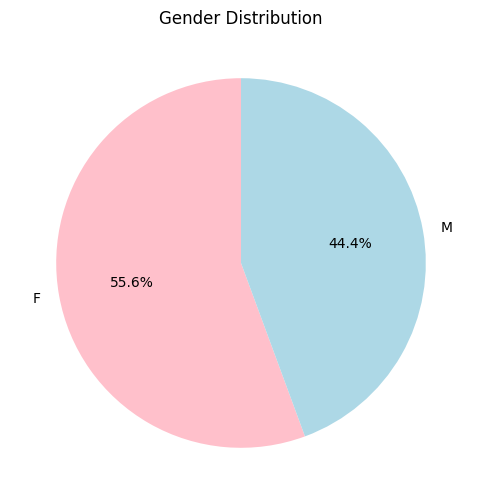

Dataset Source Counts:
 dataset
crema      6986
tess       2000
ravdess    1152
savee       420
Name: count, dtype: int64


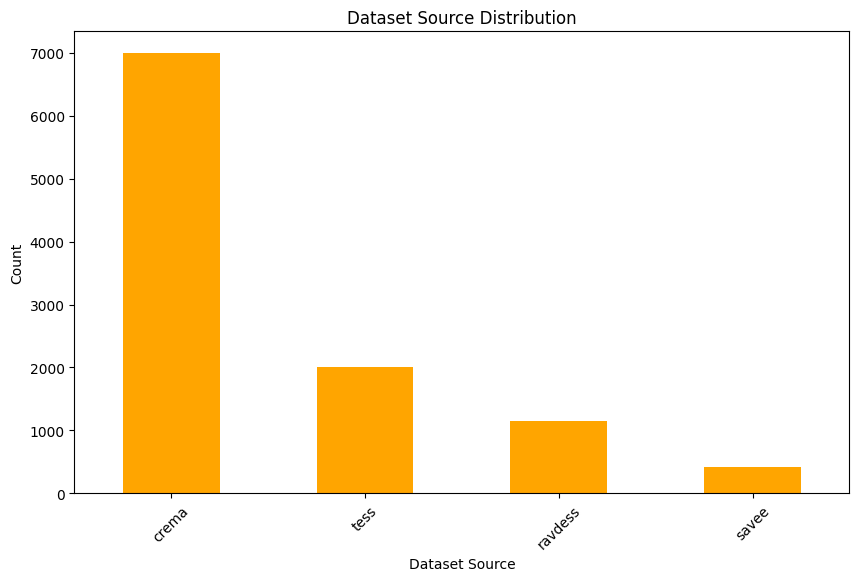

In [ ]:
#Visualize dataset distribution
# Emotion Distribution
import matplotlib.pyplot as plt

emotion_counts = data['emotion'].value_counts()
print("Emotion Counts:\n", emotion_counts)
plt.figure(figsize=(10, 6))
emotion_counts.plot(kind='bar', color='skyblue')
plt.title('Emotion Distribution')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Intensity Distribution
intensity_counts = data['intensity'].value_counts()
print("Intensity Counts:\n", intensity_counts)
plt.figure(figsize=(6, 6))
intensity_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'gold', 'skyblue'])
plt.title('Intensity Distribution')
plt.ylabel('')
plt.show()

# Gender Distribution
gender_counts = data['gender'].value_counts()
print("Gender Counts:\n", gender_counts)
plt.figure(figsize=(6, 6))
gender_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['pink', 'lightblue'])
plt.title('Gender Distribution')
plt.ylabel('')
plt.show()

# Dataset Source Distribution
dataset_counts = data['dataset'].value_counts()
print("Dataset Source Counts:\n", dataset_counts)
plt.figure(figsize=(10, 6))
dataset_counts.plot(kind='bar', color='orange')
plt.title('Dataset Source Distribution')
plt.xlabel('Dataset Source')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


In [ ]:
# Load the train, validation, and test datasets (assuming emotion labels are already in the CSVs)
train = pd.read_csv(os.path.join('/content/SpeechToEmotions_Grp3', 'train_data.csv'))  # Specify the full path
val = pd.read_csv(os.path.join('/content/SpeechToEmotions_Grp3', 'val_data.csv'))  # Specify the full path
test = pd.read_csv(os.path.join('/content/SpeechToEmotions_Grp3', 'test_data.csv'))  # Specify the full path

# Assuming 'emotion' column exists in the CSVs, you don't need the infer_emotion_from_path function
print(train.head())
print(val.head())
print(test.head())


                                                path emotion intensity gender  \
0  ./standardised_datasets/SAVEE/06_01_M_savee_KL...    fear    normal      M   
1  ./standardised_datasets/SAVEE/06_01_M_savee_JK...    fear    normal      M   
2  ./standardised_datasets/SAVEE/03_01_M_savee_DC...   happy    normal      M   
3  ./standardised_datasets/SAVEE/05_01_M_savee_JK...   angry    normal      M   
4  ./standardised_datasets/SAVEE/05_01_M_savee_JK...   angry    normal      M   

  dataset extra_info  
0   savee      KL_05  
1   savee      JK_09  
2   savee      DC_07  
3   savee      JK_10  
4   savee      JK_04  
                                                path emotion intensity gender  \
0  ./standardised_datasets/SAVEE/06_01_M_savee_KL...    fear    normal      M   
1  ./standardised_datasets/SAVEE/03_01_M_savee_DC...   happy    normal      M   
2  ./standardised_datasets/SAVEE/05_01_M_savee_JE...   angry    normal      M   
3  ./standardised_datasets/SAVEE/05_01_M_savee_JK..

## Data Cleaning of audios

In [ ]:
pip install pydub

In [ ]:
import os
from pydub.silence import detect_silence
from pydub import AudioSegment
import noisereduce as nr
import numpy as np
from scipy.signal import butter, filtfilt
from scipy.io import wavfile
import shutil

In [ ]:
# Function to apply audio sharpening using a basic filter
def sharpen_audio(data, rate, alpha=1.5, padlen=50):
    """
    Sharpen the audio signal using a high-pass filter.
    - Skips filtering if the signal is too short.
    """
    if len(data) <= padlen:
        print(f"Audio too short for filtering (len={len(data)} samples), skipping sharpening...")
        return data  # Return unmodified data

    b, a = butter(1, 0.05, btype="highpass", fs=rate)  # High-pass filter
    sharpened_data = filtfilt(b, a, data, padlen=padlen)
    return np.clip(alpha * sharpened_data, -32768, 32767).astype(np.int16)


def trim_silence(audio, silence_thresh=-80, padding=100):
    """
    Trims silence at the beginning and end of an audio segment.

    Parameters:
    - audio: AudioSegment, the input audio to process
    - silence_thresh: Silence threshold in dB (default: -40 dB)
    - padding: Milliseconds of padding to keep around the non-silent parts

    Returns:
    - Trimmed AudioSegment
    """
    # Detect silent parts: list of (start_ms, end_ms) where silence is detected
    silence_ranges = detect_silence(audio, min_silence_len=200, silence_thresh=silence_thresh)

    if not silence_ranges:
        # If no silence is detected, return the original audio
        return audio

    # Calculate the non-silent part
    start_trim = silence_ranges[0][1]  # End of the first silent range
    end_trim = silence_ranges[-1][0]   # Start of the last silent range

    # Trim silence with padding
    trimmed_audio = audio[max(0, start_trim - padding): min(len(audio), end_trim + padding)]
    return trimmed_audio


def process_wav(input_path, output_path, min_duration_sec=1):
    try:
        # Load audio
        audio = AudioSegment.from_wav(input_path)
        raw_data = np.array(audio.get_array_of_samples())

        # Noise reduction (this step happens before trimming silence)
        audio_data = np.array(audio.get_array_of_samples())
        audio_data = nr.reduce_noise(y=audio_data, sr=audio.frame_rate)

        # Convert back to AudioSegment after noise reduction
        noise_reduced_audio = AudioSegment(
            audio_data.tobytes(),
            frame_rate=audio.frame_rate,
            sample_width=audio.sample_width,
            channels=audio.channels,
        )

        # Trim silence
        trimmed_audio = trim_silence(noise_reduced_audio)  # Silence trimming function
        raw_data = np.array(trimmed_audio.get_array_of_samples())

        # Check if trimmed audio is too short (1 second minimum, based on the sample rate)
        rate = trimmed_audio.frame_rate
        min_samples = min_duration_sec * rate  # Convert seconds to samples
        if len(raw_data) < min_samples:  # Compare length with minimum required samples
            print(f"Trimmed audio too short ({len(raw_data)} samples), skipping processing.")
            return

        # Sharpen the audio
        sharpened_data = sharpen_audio(raw_data, rate, padlen=30)

        # Convert back to AudioSegment
        output_audio = AudioSegment(
            sharpened_data.tobytes(),
            frame_rate=rate,
            sample_width=trimmed_audio.sample_width,
            channels=trimmed_audio.channels,
        )

        # Save output
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        output_audio.export(output_path, format="wav")
        print(f"Saved: {output_path}")

    except Exception as e:
        print(f"Error processing {input_path}: {e}")

In [ ]:
# Function to walk through folders and process all wav files
def process_folder(input_root, output_root, min_duration_sec=1):
    for root, _, files in os.walk(input_root):
        for file in files:
            if file.endswith(".wav"):
                input_path = os.path.join(root, file)

                # Replicate folder structure in output directory
                relative_path = os.path.relpath(root, input_root)
                output_path = os.path.join(output_root, relative_path, file)

                # Process the file
                process_wav(input_path, output_path, min_duration_sec)


def copy_missing_files(content1_dir, content2_dir):
    """
    Check for missing .wav files in content2, and copy them over from content1.

    Parameters:
    - content1_dir: Directory where original files are located.
    - content2_dir: Directory where files need to be checked and copied to.
    """
    # Walk through content1 directory
    for root, dirs, files in os.walk(content1_dir):
        for file in files:
            if file.endswith(".wav"):
                # Construct the relative path from content1
                rel_path = os.path.relpath(root, content1_dir)
                content2_path = os.path.join(content2_dir, rel_path)

                # If the file doesn't exist in content2, copy it
                if not os.path.exists(os.path.join(content2_path, file)):
                    print(f"Missing file: {file}. Copying it to content2...")
                    # Ensure the target directory exists
                    os.makedirs(content2_path, exist_ok=True)
                    # Copy the file
                    shutil.copy2(os.path.join(root, file), os.path.join(content2_path, file))
                else:
                    print(f"File {file} already exists in content2, skipping.")

input_directory = "content"  # Replace with the path to your input folder
output_directory = "content2"  # Replace with the path to save cleaned files

# Clear the output directory if it exists
if os.path.exists(output_directory):
    shutil.rmtree(output_directory)

print("Starting audio processing...")
process_folder(input_directory, output_directory, min_duration_sec=1)
copy_missing_files(input_directory, output_directory)
print("Audio processing completed.")

In [ ]:
import os
import shutil
import pandas as pd
import librosa

# Directories for training, validation, and test datasets
train_dir = '/content/train'
val_dir = '/content/val'
test_dir = '/content/test'

# Function to load dataset with emotion information
def load_dataset_with_emotions(directory):
    """Load dataset from a directory and return a DataFrame with path and emotion info."""
    file_paths = []
    emotions = []

    # Iterate through the emotion categories (subdirectories)
    for emotion in os.listdir(directory):
        emotion_dir = os.path.join(directory, emotion)

        if os.path.isdir(emotion_dir):
            # Iterate through files in each emotion directory
            for file in os.listdir(emotion_dir):
                if file.endswith('.wav'):
                    file_paths.append(os.path.join(emotion_dir, file))
                    emotions.append(emotion)  # Use the folder name as the emotion label

    return pd.DataFrame({'Path': file_paths, 'Emotion': emotions})

# Load the datasets
train = load_dataset_with_emotions(train_dir)
val = load_dataset_with_emotions(val_dir)
test = load_dataset_with_emotions(test_dir)

# Create lists to store processed audio data and their sample rates
audio_data = []
sample_rates = []
problematic_files = []

def process_audio_files(data_path_filtered, audio_data, sample_rates, problematic_files):
    """Process audio files, loading them and storing their data."""
    for index, row in data_path_filtered.iterrows():
        file_path = row['Path']  # Access the file path for the current row
        try:
            # Load the audio file
            data, sr = librosa.load(file_path, sr=None)  # Set sr=None to keep the original sampling rate
            audio_data.append(data)
            sample_rates.append(sr)
        except Exception as e:
            # Handle cases where the file could not be loaded
            print(f"Error loading file: {file_path}, Error: {e}")
            problematic_files.append(file_path)

# Process the validation and test datasets
print("Processing validation dataset...")
process_audio_files(val, audio_data, sample_rates, problematic_files)

print("Processing test dataset...")
process_audio_files(test, audio_data, sample_rates, problematic_files)

print("Processing train dataset...")
process_audio_files(train, audio_data, sample_rates, problematic_files)

# Check the sample rates
print("Unique sample rates in validation and test datasets:")
print(set(sample_rates))

# Save problematic files for debugging
if problematic_files:
    with open("problematic_files.txt", "w") as f:
        for file in problematic_files:
            f.write(file + "\n")
    print("Problematic files saved to 'problematic_files.txt'")

# Display the datasets
print("Validation Dataset:")
print(val.head())
print("Test Dataset:")
print(test.head())
print("Train Dataset:")
print(train.head())

Processing validation dataset...
Processing test dataset...
Processing train dataset...
Unique sample rates in validation and test datasets:
{16000, 44100, 48000, 24414}
Validation Dataset:
                                          Path Emotion
0   /content/val/sad/04_01_F_tess_YAF_door.wav     sad
1  /content/val/sad/04_03_M_crema_1027_WSI.wav     sad
2  /content/val/sad/04_03_M_crema_1026_MTI.wav     sad
3  /content/val/sad/04_02_M_crema_1087_IEO.wav     sad
4  /content/val/sad/04_03_F_crema_1004_IOM.wav     sad
Test Dataset:
                                           Path Emotion
0   /content/test/sad/04_01_F_tess_YAF_five.wav     sad
1  /content/test/sad/04_03_M_crema_1015_IWL.wav     sad
2  /content/test/sad/04_03_M_crema_1057_IWL.wav     sad
3     /content/test/sad/04_01_M_savee_JE_05.wav     sad
4  /content/test/sad/04_03_M_crema_1081_TIE.wav     sad
Train Dataset:
                                             Path Emotion
0   /content/train/sad/04_01_F_crema_1053_IEO.wav     sad

In [ ]:
# Function to check and display unique emotions and their counts in a dataset
def check_emotion_distribution(df, dataset_name):
    """Print the unique emotions and their counts in a given dataset."""
    emotion_counts = df['Emotion'].value_counts()
    print(f"Emotion distribution in {dataset_name} dataset:")
    print(emotion_counts)
    print()

# Check the unique emotions in train, validation, and test datasets
check_emotion_distribution(train, "Train")
check_emotion_distribution(val, "Validation")
check_emotion_distribution(test, "Test")

Emotion distribution in Train dataset:
Emotion
happy      1304
neutral    1274
angry      1272
disgust    1266
sad        1148
fear       1126
Name: count, dtype: int64

Emotion distribution in Validation dataset:
Emotion
disgust    283
angry      280
happy      264
neutral    262
fear       253
sad        242
Name: count, dtype: int64

Emotion distribution in Test dataset:
Emotion
disgust    283
angry      280
happy      264
neutral    263
fear       253
sad        241
Name: count, dtype: int64



In [ ]:
import collections

#Check unique sampling rates and their counts
sr_counts = collections.Counter(sample_rates)

# Find the most common sampling rate
most_common_sr = sr_counts.most_common(1)[0] if sr_counts else (None, 0)

# Print results
print("Sampling rate counts across files:")
for rate, count in sr_counts.items():
    print(f"{rate} Hz: {count} files")

print(f"\nMost common sampling rate: {most_common_sr[0]} Hz ({most_common_sr[1]} files)")

Sampling rate counts across files:
24414 Hz: 2000 files
16000 Hz: 6986 files
48000 Hz: 1152 files
44100 Hz: 420 files

Most common sampling rate: 16000 Hz (6986 files)


In [ ]:
# Iterate over the train data to load audio files
for index, row in train.iterrows():
    file_path = row['Path']  # Access the file path for the current row
    data, sr = librosa.load(file_path) #setting all audios to sr = 22050
sr

22050

In [ ]:
# Iterate over the  val dataset to load audio files
for index, row in val.iterrows():
    file_path = row['Path']  # Access the file path for the current row
    data, sr = librosa.load(file_path) #setting all audios to sr = 22050
sr

22050

In [ ]:
# Iterate over the  test dataset to load audio files
for index, row in test.iterrows():
    file_path = row['Path']  # Access the file path for the current row
    data, sr = librosa.load(file_path) #setting all audios to sr = 22050
sr

22050

In [ ]:
from IPython.display import Audio

# Load and play individual audio file for validation class
indiv_file_path = val.iloc[0]['Path']  # Access the first file path (index 0)
indiv_file_data, indiv_file_sr = librosa.load(indiv_file_path)  # Load the first audio file
print(f"Playing individual audio file: {indiv_file_path}")
Audio(indiv_file_data, rate=indiv_file_sr)

Playing individual audio file: /content/val/sad/04_01_F_tess_YAF_door.wav


In [ ]:
from IPython.display import Audio

# Load and play individual audio file for train class
indiv_file_path = train.iloc[0]['Path']  # Access the first file path (index 0)
indiv_file_data, indiv_file_sr = librosa.load(indiv_file_path)  # Load the first audio file
print(f"Playing individual audio file: {indiv_file_path}")
Audio(indiv_file_data, rate=indiv_file_sr)

Playing individual audio file: /content/train/sad/04_01_F_crema_1053_IEO.wav


In [ ]:
from IPython.display import Audio

# Load and play individual audio file for test class
indiv_file_path = test.iloc[0]['Path']  # Access the first file path (index 0)
indiv_file_data, indiv_file_sr = librosa.load(indiv_file_path)  # Load the first audio file
print(f"Playing individual audio file: {indiv_file_path}")
Audio(indiv_file_data, rate=indiv_file_sr)

Playing individual audio file: /content/test/sad/04_01_F_tess_YAF_five.wav


# Data Argumentation

Playing individual audio file: /content/train/sad/04_01_F_crema_1053_IEO.wav


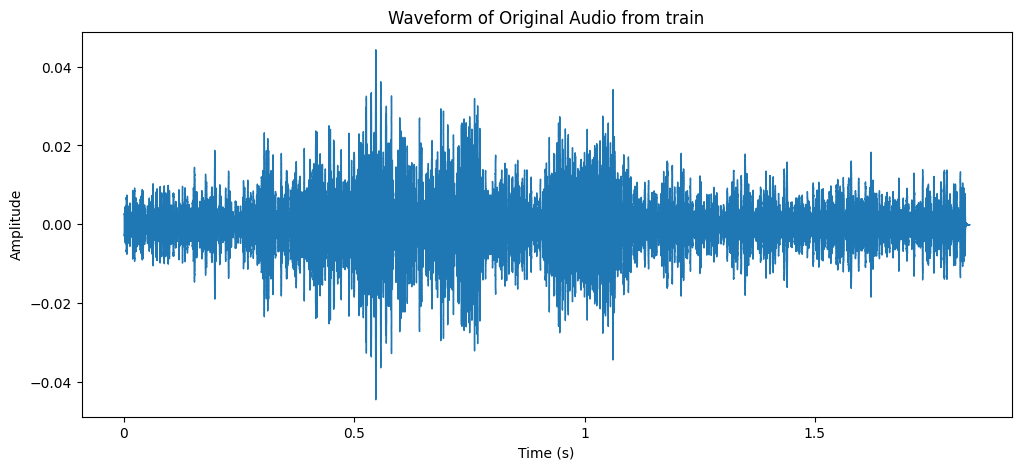

In [ ]:
import matplotlib.pyplot as plt
# Load and play an individual audio file
indiv_file_index = 0  # Index of the audio file you want to play
indiv_file_path = train.iloc[indiv_file_index]['Path']  # Access the file path
indiv_file_data, indiv_file_sr = librosa.load(indiv_file_path)  # Load the audio file
print(f"Playing individual audio file: {indiv_file_path}")

# Plot the waveform of the audio file
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=indiv_file_data, sr=indiv_file_sr)
plt.title(f"Waveform of Original Audio from train")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

# Play the audio
Audio(indiv_file_data, rate=indiv_file_sr)

Playing individual audio file: /content/val/sad/04_01_F_tess_YAF_door.wav


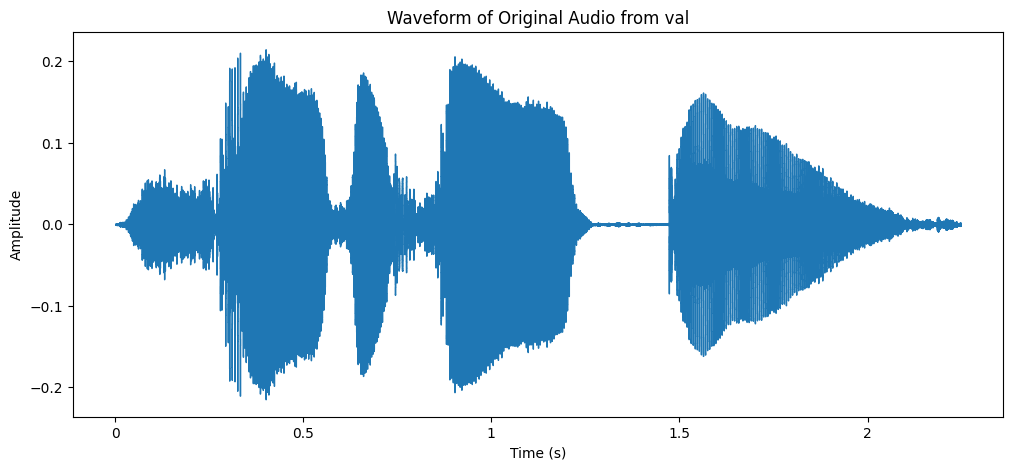

In [ ]:
import matplotlib.pyplot as plt
# Load and play an individual audio file
indiv_file_index = 0  # Index of the audio file you want to play
indiv_file_path = val.iloc[indiv_file_index]['Path']  # Access the file path
indiv_file_data, indiv_file_sr = librosa.load(indiv_file_path)  # Load the audio file
print(f"Playing individual audio file: {indiv_file_path}")

# Plot the waveform of the audio file
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=indiv_file_data, sr=indiv_file_sr)
plt.title(f"Waveform of Original Audio from val")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

# Play the audio
Audio(indiv_file_data, rate=indiv_file_sr)

Processing individual audio file: /content/train/sad/04_01_F_crema_1053_IEO.wav


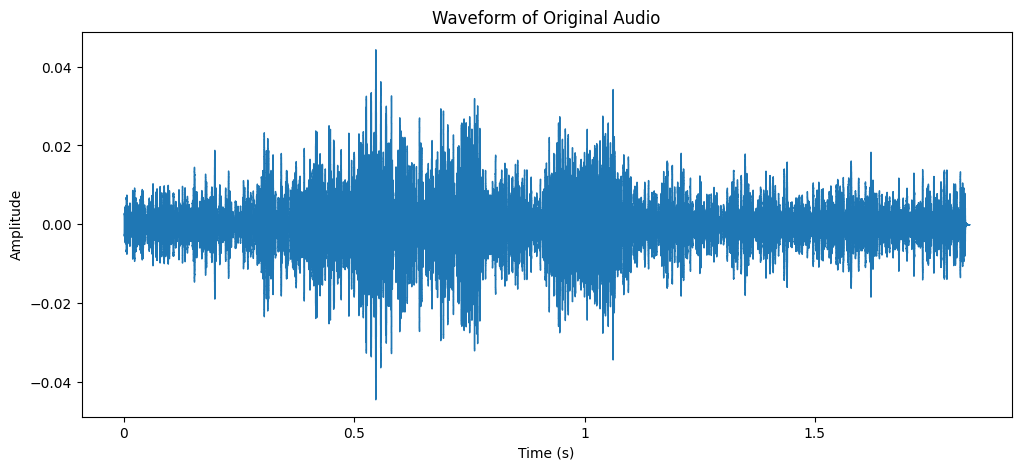

Playing original audio:


Playing noisy audio:


Playing pitch-shifted audio:


Playing time-stretched audio:


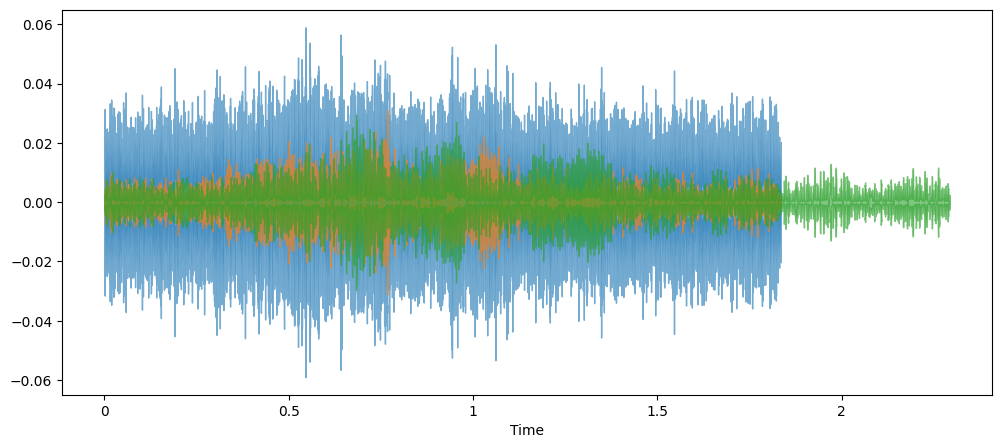

In [ ]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio

# Function to add noise
def add_noise(audio, noise_level=0.005):
    """
    Adds white noise to the audio.
    Parameters:
        audio (ndarray): Audio time-series data.
        noise_level (float): Amplitude of the noise to add.
    Returns:
        ndarray: Audio with added noise.
    """
    noise = np.random.randn(len(audio)) * noise_level
    return audio + noise

# Function for pitch shifting
def pitch_shift(audio, sr, n_steps=2):
    """
    Shifts the pitch of the audio.
    Parameters:
        audio (ndarray): Audio time-series data.
        sr (int): Sampling rate of the audio.
        n_steps (int): Number of semitones to shift (positive or negative).
    Returns:
        ndarray: Pitch-shifted audio.
    """
    return librosa.effects.pitch_shift(audio, sr=sr, n_steps=n_steps)

# Function for time stretching
def time_stretch(audio, rate=1.2):
    """
    Stretches or compresses the audio in time.
    Parameters:
        audio (ndarray): Audio time-series data.
        rate (float): Stretch factor (>1.0 for slower, <1.0 for faster).
    Returns:
        ndarray: Time-stretched audio.
    """
    return librosa.effects.time_stretch(audio, rate=rate)

# Load and play an individual audio file
indiv_file_index = 0  # Index of the audio file to process
indiv_file_path = train.iloc[indiv_file_index]['Path']  # Get file path
indiv_file_data, indiv_file_sr = librosa.load(indiv_file_path)  # Load the audio file
print(f"Processing individual audio file: {indiv_file_path}")

# Plot original waveform
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=indiv_file_data, sr=indiv_file_sr)
plt.title("Waveform of Original Audio")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

# Play the original audio
print("Playing original audio:")
display(Audio(indiv_file_data, rate=indiv_file_sr))

# Data Augmentation: Add noise
noisy_audio = add_noise(indiv_file_data, noise_level=0.01)
print("Playing noisy audio:")
display(Audio(noisy_audio, rate=indiv_file_sr))

# Data Augmentation: Pitch shift
pitch_shifted_audio = pitch_shift(indiv_file_data, sr=indiv_file_sr, n_steps=3)
print("Playing pitch-shifted audio:")
display(Audio(pitch_shifted_audio, rate=indiv_file_sr))

# Data Augmentation: Time stretch
time_stretched_audio = time_stretch(indiv_file_data, rate=0.8)
print("Playing time-stretched audio:")
display(Audio(time_stretched_audio, rate=indiv_file_sr))

# Plot augmented waveforms
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=noisy_audio, sr=indiv_file_sr, alpha=0.6, label="Noisy")
librosa.display.waveshow(y=pitch_shifted_audio, sr=indiv_file_sr, alpha=0.6, label="Pitch-Shifted")
librosa.display.waveshow(y=time_stretched_audio, sr=indiv_file_sr, alpha=0.6, label="Time-Stretched")


Processing individual audio file: /content/val/sad/04_01_F_tess_YAF_door.wav


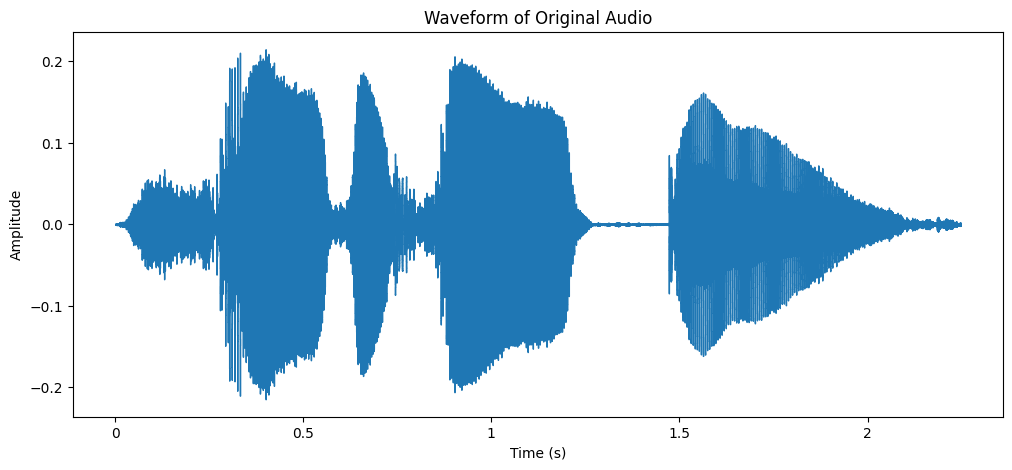

Playing original audio:


Playing noisy audio:


Playing pitch-shifted audio:


Playing time-stretched audio:


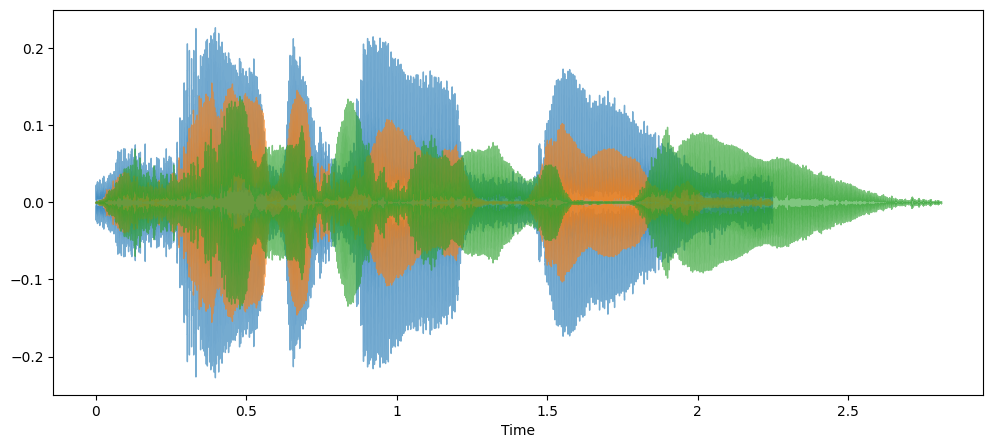

In [ ]:
# Load and play an individual audio file
indiv_file_index = 0  # Index of the audio file to process
indiv_file_path = val.iloc[indiv_file_index]['Path']  # Get file path
indiv_file_data, indiv_file_sr = librosa.load(indiv_file_path)  # Load the audio file
print(f"Processing individual audio file: {indiv_file_path}")

# Plot original waveform
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=indiv_file_data, sr=indiv_file_sr)
plt.title("Waveform of Original Audio")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

# Play the original audio
print("Playing original audio:")
display(Audio(indiv_file_data, rate=indiv_file_sr))

# Data Augmentation: Add noise
noisy_audio = add_noise(indiv_file_data, noise_level=0.01)
print("Playing noisy audio:")
display(Audio(noisy_audio, rate=indiv_file_sr))

# Data Augmentation: Pitch shift
pitch_shifted_audio = pitch_shift(indiv_file_data, sr=indiv_file_sr, n_steps=3)
print("Playing pitch-shifted audio:")
display(Audio(pitch_shifted_audio, rate=indiv_file_sr))

# Data Augmentation: Time stretch
time_stretched_audio = time_stretch(indiv_file_data, rate=0.8)
print("Playing time-stretched audio:")
display(Audio(time_stretched_audio, rate=indiv_file_sr))

# Plot augmented waveforms
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=noisy_audio, sr=indiv_file_sr, alpha=0.6, label="Noisy")
librosa.display.waveshow(y=pitch_shifted_audio, sr=indiv_file_sr, alpha=0.6, label="Pitch-Shifted")
librosa.display.waveshow(y=time_stretched_audio, sr=indiv_file_sr, alpha=0.6, label="Time-Stretched")


#Feature Extraction

In [ ]:
# Audio feature extraction functions
def zcr(data, frame_length=2048, hop_length=512):
    """Extract Zero-Crossing Rate."""
    zcr = librosa.feature.zero_crossing_rate(data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(zcr)

def rmse(data, frame_length=2048, hop_length=512):
    """Extract Root Mean Square Energy."""
    rmse = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rmse)

def mfcc(data, sr=22050, frame_length=2048, hop_length=512, flatten: bool = True):
    """Extract Mel-Frequency Cepstral Coefficients."""
    mfcc = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=13)
    return np.squeeze(mfcc.T) if not flatten else np.ravel(mfcc.T)

def extract_features(data, sr=22050, frame_length=2048, hop_length=512):
    """Combine extracted features into a single array."""
    result = np.array([])
    result = np.hstack((
        zcr(data, frame_length, hop_length),
        rmse(data, frame_length, hop_length),
        mfcc(data, sr, frame_length, hop_length)
    ))
    return result

# # Augmentation functions
# def add_noise(audio, noise_level=0.005):
#     """Add white noise to the audio."""
#     noise = np.random.randn(len(audio)) * noise_level
#     return audio + noise

# def pitch_shift(audio, sr, n_steps=2):
#     """Shift the pitch of the audio."""
#     return librosa.effects.pitch_shift(audio, sr=sr, n_steps=n_steps)

# def time_stretch(audio, rate=1.2):
#     """Stretch or compress the audio."""
#     return librosa.effects.time_stretch(audio, rate=rate)

# def get_features(path, duration=2.5, offset=0.6):
#     """Extract features with augmentations from an audio file."""
#     data, sr = librosa.load(path, duration=duration, offset=offset)
#     features = []

#     # Original features
#     original_features = extract_features(data, sr)
#     features.append(original_features)

#     # Noised audio features
#     noised_audio = add_noise(data)
#     noised_features = extract_features(noised_audio, sr)
#     features.append(noised_features)

#     # # Pitch-shifted audio features
#     # pitched_audio = pitch_shift(data, sr, n_steps=np.random.randint(-3, 3))
#     # pitched_features = extract_features(pitched_audio, sr)
#     # features.append(pitched_features)

#     # # Pitch-shifted + noised audio features
#     # pitched_noised_audio = add_noise(pitched_audio)
#     # pitched_noised_features = extract_features(pitched_noised_audio, sr)
#     # features.append(pitched_noised_features)

#     # Apply augmentations with 30% probability
#     if np.random.rand() < 0.3:
#         # Choose a random augmentation
#         augmentation_type = np.random.choice(['noise']) #you can include , 'pitch_shift', 'time_stretch'])

#         if augmentation_type == 'noise':
#             augmented_data = add_noise(data)
#             augmented_features = extract_features(augmented_data, sr)
#             features.append(augmented_features)

# Augmentation functions
def add_noise(audio, noise_level=0.005):
    """Add white noise to the audio."""
    noise = np.random.randn(len(audio)) * noise_level
    return audio + noise

# Add Pitch Shift
def pitch_shift(audio, sr, n_steps=2):
    return librosa.effects.pitch_shift(audio, sr=sr, n_steps=n_steps)

# Add Time Stretch
def time_stretch(audio, rate=1.2):
    return librosa.effects.time_stretch(audio, rate=rate)

def get_features(path, duration=2.5, offset=0.6):
    data, sr = librosa.load(path, duration=duration, offset=offset)
    features = []

    # Original features
    features.append(extract_features(data, sr))

    # Augmentations
    augmentations = ['noise', 'pitch_shift','time_stretch']
    for aug in augmentations:
        if np.random.rand() < 0.3:
            if aug == 'noise':
                augmented_data = add_noise(data)
            elif aug == 'pitch_shift':
                augmented_data = pitch_shift(data, sr, n_steps=np.random.randint(-3, 3))
            elif aug == 'time_stretch':
                augmented_data = time_stretch(data, rate=np.random.uniform(0.8, 1.2))

            features.append(extract_features(augmented_data, sr))
    # Apply pad_or_truncate to make features with same length
        target_length = 1620 #change this depending on feature dimension.
        features = [pad_or_truncate(feature, target_length) for feature in features]

    return np.vstack(features)


## extract train features

In [ ]:
import timeit
# Dataset feature extraction with timing and progress monitoring
start = timeit.default_timer()
X, Y = [], []


In [ ]:
print(train.columns)  # Check the column names

Index(['Path', 'Emotion'], dtype='object')


In [ ]:
from tqdm import tqdm
import timeit
import numpy as np

# Helper function to pad or truncate feature vectors
def pad_or_truncate(features, target_length):
    """Pad or truncate features to a fixed length."""
    if len(features) > target_length:
        return features[:target_length]
    elif len(features) < target_length:
        return np.pad(features, (0, target_length - len(features)), mode='constant')
    return features

# Dataset feature extraction with timing and progress monitoring
start = timeit.default_timer()
X, Y = [], []

# Define the target feature vector length
target_length = 1620  # Adjust this based on your feature dimensions

for index, (path, emotion) in tqdm(enumerate(zip(train["Path"], train["Emotion"])),
                                   total=len(train),
                                   desc="Extracting features"):
    try:
        # Extract features with augmentations
        features = get_features(path)  # Returns multiple augmented feature vectors

        # Ensure all features have consistent length
        features = [pad_or_truncate(feature, target_length) for feature in features]

        # Append each feature (including augmented ones) and its label
        for feature in features:
            X.append(feature)
            Y.append(emotion)

    except Exception as e:
        print(f"Error processing file {path}: {e}")
        continue  # Skip problematic files

    # Log progress every 500 files
    if index % 500 == 0 and index != 0:
        print(f"{index} audio files have been processed")

# Convert lists to NumPy arrays
X = np.array(X)
Y = np.array(Y)

# Stop the timer and print time taken
end = timeit.default_timer()
print(f"Feature extraction completed in {end - start:.2f} seconds.")
print(f"Extracted features shape: {X.shape}")
print(f"Labels shape: {Y.shape}")

Extracting features:   7%|▋         | 503/7390 [00:35<07:56, 14.44it/s]

500 audio files have been processed


Extracting features:  14%|█▎        | 1003/7390 [01:07<04:26, 23.94it/s]

1000 audio files have been processed


Extracting features:  20%|██        | 1504/7390 [01:37<05:34, 17.60it/s]

1500 audio files have been processed


Extracting features:  27%|██▋       | 2001/7390 [02:08<09:02,  9.93it/s]

2000 audio files have been processed


Extracting features:  34%|███▍      | 2502/7390 [02:37<08:31,  9.55it/s]

2500 audio files have been processed


Extracting features:  41%|████      | 3003/7390 [03:08<03:29, 20.97it/s]

3000 audio files have been processed


Extracting features:  47%|████▋     | 3502/7390 [03:37<03:40, 17.67it/s]

3500 audio files have been processed


Extracting features:  54%|█████▍    | 4003/7390 [04:07<03:06, 18.21it/s]

4000 audio files have been processed


Extracting features:  61%|██████    | 4505/7390 [04:38<02:41, 17.81it/s]

4500 audio files have been processed


Extracting features:  68%|██████▊   | 5003/7390 [05:13<03:03, 13.00it/s]

5000 audio files have been processed


Extracting features:  74%|███████▍  | 5503/7390 [05:46<01:56, 16.18it/s]

5500 audio files have been processed


Extracting features:  81%|████████  | 6002/7390 [06:21<03:19,  6.95it/s]

6000 audio files have been processed


Extracting features:  88%|████████▊ | 6504/7390 [06:53<00:39, 22.67it/s]

6500 audio files have been processed


Extracting features:  95%|█████████▍| 7003/7390 [07:22<00:21, 17.67it/s]

7000 audio files have been processed


Extracting features: 100%|██████████| 7390/7390 [07:47<00:00, 15.81it/s]


Feature extraction completed in 467.68 seconds.
Extracted features shape: (13975, 1620)
Labels shape: (13975,)


In [ ]:
# from tqdm import tqdm
# import timeit
# import numpy as np

# # Helper function to pad or truncate feature vectors
# def pad_or_truncate(features, target_length):
#     """Pad or truncate features to a fixed length."""
#     if len(features) > target_length:
#         return features[:target_length]
#     elif len(features) < target_length:
#         return np.pad(features, (0, target_length - len(features)), mode='constant')
#     return features

# # Dataset feature extraction with timing and progress monitoring
# start = timeit.default_timer()
# X, Y = [], []

# # Define the target feature vector length
# target_length = 512

# for index, (path, emotion) in tqdm(enumerate(zip(train["Path"], train["Emotion"])),
#                                    total=len(train),
#                                    desc="Extracting features"):
#     try:
#         # Load the audio file with a fixed duration
#         data, sr = librosa.load(path, sr=22050, duration=2.5, offset=0.6)

#         # Extract features
#         features = extract_features(data, sr)

#         # Pad or truncate features to ensure consistent length
#         features = pad_or_truncate(features, target_length)

#         # Append features and corresponding label
#         X.append(features)
#         Y.append(emotion)

#     except Exception as e:
#         print(f"Error processing file {path}: {e}")
#         continue  # Skip problematic files

#     # Log progress every 500 files
#     if index % 500 == 0 and index != 0:
#         print(f"{index} audio files have been processed")

# # Convert X and Y to NumPy arrays
# X = np.array(X)  # Now consistent shape (num_samples, num_features)
# Y = np.array(Y)  # Shape (num_samples,)

# # Stop the timer and print time taken
# end = timeit.default_timer()
# print(f"Feature extraction completed in {end - start:.2f} seconds.")
# print(f"Extracted features shape: {X.shape}")
# print(f"Labels shape: {Y.shape}")

In [ ]:
len(X), len(Y), train.Path.shape

(13975, 13975, (7390,))

In [ ]:
# SAVING FEATURES

Emotions = pd.DataFrame(X)
Emotions['Emotions'] = Y
Emotions.to_csv('emotion_train.csv', index=False)
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,1611,1612,1613,1614,1615,1616,1617,1618,1619,Emotions
0,0.020020,0.031738,0.046387,0.043945,0.045410,0.043945,0.039551,0.037109,0.038086,0.036133,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,sad
1,0.118652,0.179199,0.232910,0.229492,0.222656,0.197266,0.190918,0.218262,0.221680,0.244629,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,sad
2,0.302246,0.487305,0.604004,0.653809,0.722168,0.695312,0.705078,0.474609,0.315430,0.210938,...,0.510857,0.483352,0.450512,0.412805,0.370751,0.324915,0.275937,0.224479,0.171228,sad
3,0.250488,0.367676,0.500000,0.508789,0.495605,0.503418,0.493164,0.493652,0.505859,0.507324,...,-2.710220,-3.212982,1.639962,-0.790017,1.789483,0.740812,1.040093,2.435430,-1.304098,sad
4,0.211426,0.294922,0.396484,0.382812,0.387695,0.402344,0.390137,0.359375,0.381348,0.401367,...,-14.470121,-20.481556,29.767742,-493.383789,170.475739,3.097202,-6.947839,-24.627960,-27.285023,sad


## extract val features

In [ ]:
from tqdm import tqdm
import timeit
import numpy as np

# Helper function to pad or truncate feature vectors
def pad_or_truncate(features, target_length):
    """Pad or truncate features to a fixed length."""
    if len(features) > target_length:
        return features[:target_length]
    elif len(features) < target_length:
        return np.pad(features, (0, target_length - len(features)), mode='constant')
    return features

# Dataset feature extraction with timing and progress monitoring
start = timeit.default_timer()
X, Y = [], []

# Define the target feature vector length
target_length = 1620

for index, (path, emotion) in tqdm(enumerate(zip(val["Path"], val["Emotion"])),
                                   total=len(val),
                                   desc="Extracting features"):
    try:
        # Load the audio file with a fixed duration
        data, sr = librosa.load(path, sr=22050, duration=2.5, offset=0.6)

        # Extract features
        features = extract_features(data, sr)

        # Pad or truncate features to ensure consistent length
        features = pad_or_truncate(features, target_length)

        # Append features and corresponding label
        X.append(features)
        Y.append(emotion)

    except Exception as e:
        print(f"Error processing file {path}: {e}")
        continue  # Skip problematic files

    # Log progress every 500 files
    if index % 500 == 0 and index != 0:
        print(f"{index} audio files have been processed")

# Convert X and Y to NumPy arrays
X = np.array(X)  # Now consistent shape (num_samples, num_features)
Y = np.array(Y)  # Shape (num_samples,)

# Stop the timer and print time taken
end = timeit.default_timer()
print(f"Feature extraction completed in {end - start:.2f} seconds.")
print(f"Extracted features shape: {X.shape}")
print(f"Labels shape: {Y.shape}")

Extracting features:  32%|███▏      | 509/1584 [00:14<00:24, 43.93it/s]

500 audio files have been processed


Extracting features:  64%|██████▎   | 1006/1584 [00:28<00:15, 36.52it/s]

1000 audio files have been processed


Extracting features:  95%|█████████▍| 1504/1584 [00:43<00:03, 24.00it/s]

1500 audio files have been processed


Extracting features: 100%|██████████| 1584/1584 [00:45<00:00, 35.15it/s]

Feature extraction completed in 45.11 seconds.
Extracted features shape: (1584, 1620)
Labels shape: (1584,)


In [ ]:
# SAVING FEATURES

Emotions = pd.DataFrame(X)
Emotions['Emotions'] = Y
Emotions.to_csv('emotion_val.csv', index=False)
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,1611,1612,1613,1614,1615,1616,1617,1618,1619,Emotions
0,0.019531,0.025879,0.032227,0.025879,0.024902,0.020996,0.020020,0.020508,0.020508,0.024414,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,sad
1,0.077148,0.141113,0.206543,0.205566,0.177734,0.132324,0.081055,0.063477,0.063965,0.054199,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,sad
2,0.014648,0.021484,0.026855,0.028320,0.031738,0.036621,0.043457,0.047852,0.050293,0.051270,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,sad
3,0.069824,0.173828,0.287109,0.372559,0.428223,0.383789,0.278809,0.172363,0.082031,0.030273,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,sad
4,0.041016,0.051270,0.058105,0.043945,0.042969,0.053223,0.069336,0.081055,0.079590,0.068359,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,sad


## extract test features

In [ ]:
from tqdm import tqdm
import timeit
import numpy as np

# Helper function to pad or truncate feature vectors
def pad_or_truncate(features, target_length):
    """Pad or truncate features to a fixed length."""
    if len(features) > target_length:
        return features[:target_length]
    elif len(features) < target_length:
        return np.pad(features, (0, target_length - len(features)), mode='constant')
    return features

# Dataset feature extraction with timing and progress monitoring
start = timeit.default_timer()
X, Y = [], []

# Define the target feature vector length
target_length = 1620

for index, (path, emotion) in tqdm(enumerate(zip(test["Path"], test["Emotion"])),
                                   total=len(test),
                                   desc="Extracting features"):
    try:
        # Load the audio file with a fixed duration
        data, sr = librosa.load(path, sr=22050, duration=2.5, offset=0.6)

        # Extract features
        features = extract_features(data, sr)

        # Pad or truncate features to ensure consistent length
        features = pad_or_truncate(features, target_length)

        # Append features and corresponding label
        X.append(features)
        Y.append(emotion)

    except Exception as e:
        print(f"Error processing file {path}: {e}")
        continue  # Skip problematic files

    # Log progress every 500 files
    if index % 500 == 0 and index != 0:
        print(f"{index} audio files have been processed")

# Convert X and Y to NumPy arrays
X = np.array(X)  # Now consistent shape (num_samples, num_features)
Y = np.array(Y)  # Shape (num_samples,)

# Stop the timer and print time taken
end = timeit.default_timer()
print(f"Feature extraction completed in {end - start:.2f} seconds.")
print(f"Extracted features shape: {X.shape}")
print(f"Labels shape: {Y.shape}")


Extracting features:  32%|███▏      | 507/1584 [00:15<00:24, 43.23it/s]

500 audio files have been processed


Extracting features:  64%|██████▎   | 1009/1584 [00:29<00:12, 46.64it/s]

1000 audio files have been processed


Extracting features:  95%|█████████▌| 1507/1584 [00:44<00:01, 41.39it/s]

1500 audio files have been processed


Extracting features: 100%|██████████| 1584/1584 [00:46<00:00, 34.06it/s]

Feature extraction completed in 46.53 seconds.
Extracted features shape: (1584, 1620)
Labels shape: (1584,)


In [ ]:
# SAVING FEATURES

Emotions = pd.DataFrame(X)
Emotions['Emotions'] = Y
Emotions.to_csv('emotion_test.csv', index=False)
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,1611,1612,1613,1614,1615,1616,1617,1618,1619,Emotions
0,0.020996,0.026855,0.032715,0.026367,0.025391,0.028809,0.030762,0.036621,0.037598,0.034180,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,sad
1,0.013672,0.017090,0.028320,0.028809,0.029297,0.033203,0.029297,0.032227,0.039551,0.054199,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,sad
2,0.025391,0.041992,0.049316,0.046387,0.038574,0.032227,0.034180,0.034180,0.035156,0.034180,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,sad
3,0.000977,0.003418,0.011230,0.019531,0.028320,0.034180,0.035645,0.035156,0.034668,0.030762,...,2.462493,18.696962,0.024956,-16.627735,16.490314,-13.425648,-3.96069,5.564983,1.454539,sad
4,0.023438,0.033203,0.040039,0.070312,0.067383,0.070801,0.072754,0.042480,0.039551,0.043457,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,sad


# Feature Normalization

In [ ]:
# Load Extracted features

Emotions_train = pd.read_csv('emotion_train.csv')
Emotions_train.head()


,0,1,2,3,4,5,6,7,8,9,...,1611,1612,1613,1614,1615,1616,1617,1618,1619,Emotions
0,0.027344,0.125977,0.242188,0.374023,0.489258,0.540039,0.574707,0.598633,0.616699,0.632812,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,happy
1,0.027344,0.125977,0.242188,0.374023,0.489258,0.540039,0.574707,0.598633,0.616699,0.632812,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,happy
2,0.226074,0.406738,0.608887,0.738770,0.803223,0.833984,0.838379,0.838379,0.851074,0.848633,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,happy
3,0.224121,0.395508,0.583984,0.694336,0.755371,0.785645,0.790527,0.786621,0.796875,0.783691,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,happy
4,0.006836,0.014648,0.023438,0.023438,0.023438,0.023926,0.031738,0.037109,0.037109,0.031250,...,25.126312,23.125212,20.823605,18.298166,15.631202,12.907238,10.209601,7.617077,5.200905,happy


In [ ]:
unique_emotions_train = Emotions_train['Emotions'].unique()

# Display unique emotions
print(unique_emotions_train)

['happy' 'sad' 'fear' 'angry' 'disgust' 'neutral']


In [ ]:
Emotions_val = pd.read_csv("emotion_val.csv")
Emotions_val.head()

,0,1,2,3,4,5,6,7,8,9,...,1611,1612,1613,1614,1615,1616,1617,1618,1619,Emotions
0,0.211426,0.351562,0.495605,0.549805,0.573242,0.580078,0.585938,0.602051,0.611328,0.622559,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,happy
1,0.010742,0.016602,0.028320,0.030273,0.034180,0.054688,0.138672,0.275391,0.417969,0.542480,...,43.544926,36.880768,29.718441,22.476109,15.531132,9.196213,3.706600,-0.782860,-4.193444,happy
2,0.020020,0.023926,0.028809,0.020508,0.018555,0.020020,0.020508,0.018555,0.021484,0.024902,...,9.216211,13.894314,12.542997,6.326210,11.723911,6.648025,3.604115,7.808209,1.031407,happy
3,0.008301,0.012695,0.019531,0.020020,0.017578,0.020508,0.017578,0.033203,0.048828,0.076172,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,happy
4,0.000000,0.134766,0.267090,0.413574,0.530762,0.490723,0.433105,0.306152,0.215820,0.145996,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,happy


In [ ]:
unique_emotions_val = Emotions_val['Emotions'].unique()

# Display unique emotions
print(unique_emotions_val)

['happy' 'sad' 'fear' 'angry' 'disgust' 'neutral']


In [ ]:
Emotions_test = pd.read_csv("emotion_testv.csv")
Emotions_test.head()

,0,1,2,3,4,5,6,7,8,9,...,1611,1612,1613,1614,1615,1616,1617,1618,1619,Emotions
0,0.020508,0.037109,0.041016,0.041992,0.032715,0.022461,0.021484,0.029785,0.029297,0.059570,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,happy
1,0.015137,0.020508,0.033691,0.023438,0.047852,0.047363,0.036133,0.037598,0.016113,0.023926,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,happy
2,0.312500,0.478027,0.636719,0.649902,0.614746,0.592773,0.580566,0.570801,0.568848,0.555176,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,happy
3,0.014160,0.017090,0.019531,0.020996,0.014160,0.015137,0.015137,0.012695,0.012695,0.015137,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,happy
4,0.054199,0.062988,0.067871,0.044434,0.024902,0.020020,0.020508,0.020020,0.018555,0.030762,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,happy


In [ ]:
unique_emotions_test = Emotions_test['Emotions'].unique()

# Display unique emotions
print(unique_emotions_test)

['happy' 'sad' 'fear' 'angry' 'disgust' 'neutral']



# Training: CNN Model

In [ ]:
# Importing necessary libraries
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np

# Load Emotions CSV data
train_data = pd.read_csv('emotion_train.csv')
val_data = pd.read_csv('emotion_val.csv')
test_data = pd.read_csv('emotion_testv.csv')

# Separate features and labels
X_train = train_data.iloc[:, :-1].values  # All columns except the last
Y_train = train_data.iloc[:, -1].values   # The last column

X_val = val_data.iloc[:, :-1].values
Y_val = val_data.iloc[:, -1].values

X_test = test_data.iloc[:, :-1].values
Y_test = test_data.iloc[:, -1].values

# Encode string labels into numerical labels
label_encoder = LabelEncoder()
Y_train = label_encoder.fit_transform(Y_train)
Y_val = label_encoder.transform(Y_val)
Y_test = label_encoder.transform(Y_test)

# Check the number of unique classes
num_classes = len(label_encoder.classes_)

# Convert labels to categorical (one-hot encoding)
Y_train = to_categorical(Y_train, num_classes=num_classes)
Y_val = to_categorical(Y_val, num_classes=num_classes)
Y_test = to_categorical(Y_test, num_classes=num_classes)

# Scale the data with sklearn's StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Handle missing values in the dataset
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_val = imputer.transform(X_val)
X_test = imputer.transform(X_test)

# Reshape for CNN_LSTM model
X_train_cnn = np.expand_dims(X_train, axis=2)
X_val_cnn = np.expand_dims(X_val, axis=2)
X_test_cnn = np.expand_dims(X_test, axis=2)

# Debugging: Verify shapes
print("X_train shape:", X_train_cnn.shape, "Y_train shape:", Y_train.shape)
print("X_val shape:", X_val_cnn.shape, "Y_val shape:", Y_val.shape)
print("X_test shape:", X_test_cnn.shape, "Y_test shape:", Y_test.shape)




X_train shape: (13928, 1620, 1) Y_train shape: (13928, 6)
X_val shape: (1584, 1620, 1) Y_val shape: (1584, 6)
X_test shape: (1584, 1620, 1) Y_test shape: (1584, 6)


In [ ]:
from sklearn.preprocessing import StandardScaler
import joblib  # For saving the scaler

# Fit the scaler on the training data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Scale training data

# Save the scaler for use during inference
joblib.dump(scaler, "scaler.pkl")
print("Scaler saved as 'scaler.pkl'.")

# Scale validation and test data using the same scaler
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Handle missing values (if not already handled)
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_val = imputer.transform(X_val)
X_test = imputer.transform(X_test)

# Reshape for CNN
X_train_cnn = np.expand_dims(X_train, axis=2)
X_val_cnn = np.expand_dims(X_val, axis=2)
X_test_cnn = np.expand_dims(X_test, axis=2)

# Verify shapes
print("X_train_cnn shape:", X_train_cnn.shape)


Scaler saved as 'scaler.pkl'.
X_train_cnn shape: (13928, 1620, 1)


In [ ]:
import joblib
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit scaler on training data
joblib.dump(scaler, "scaler.pkl")  # Save the scaler


['scaler.pkl']

In [ ]:
import pandas as pd

# Save X_test_cnn as a CSV file for testing
X_test_df = pd.DataFrame(X_test_cnn.reshape(X_test_cnn.shape[0], -1))  # Flatten for CSV format
X_test_df.to_csv('X_test_cnn.csv', index=False)

print("X_test_cnn has been saved as 'X_test_cnn.csv'.")


X_test_cnn has been saved as 'X_test_cnn.csv'.


In [ ]:
# # After your existing code where you have X_train, Y_train ready
# print("Original X_train shape:", X_train.shape)

# # 1. Add Data Augmentation
# def augment_audio_features(features):
#     augmented_features = []
#     augmented_features.append(features)  # Original features

#     # Add random noise
#     noise = np.random.normal(0, 0.001, features.shape)
#     augmented_features.append(features + noise)

#     return np.array(augmented_features)

# # Apply augmentation
# X_train_augmented = []
# Y_train_augmented = []

# for features, label in zip(X_train, Y_train):
#     augmented_features = augment_audio_features(features)
#     X_train_augmented.extend(augmented_features)
#     Y_train_augmented.extend([label] * len(augmented_features))

# X_train_augmented = np.array(X_train_augmented)
# Y_train_augmented = np.array(Y_train_augmented)

# print("Augmented X_train shape:", X_train_augmented.shape)



In [ ]:
# # Reshape augmented data for CNN
# X_train_augmented = np.expand_dims(X_train_augmented, axis=2)
# # Scale the augmented data
# scaler = StandardScaler()
# X_train_augmented = scaler.fit_transform(X_train_augmented.reshape(-1, X_train_augmented.shape[-1])).reshape(X_train_augmented.shape)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
# 2. Calculate class weights
Y_train_labels = np.argmax(Y_train, axis=1)
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(Y_train_labels),
    y=Y_train_labels
)
class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weight_dict)

Class weights: {0: 0.9745312062692415, 1: 0.9684327631761924, 2: 1.0857499220455253, 3: 0.9501978441806522, 4: 0.9628093460528135, 5: 1.0761860608870344}


In [ ]:
# Now print the number of classes
print("Number of classes:", num_classes)


Number of classes: 6


In [ ]:
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization , GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
model_checkpoint = ModelCheckpoint('best_model.weights.keras', monitor='val_accuracy', save_best_only=True, save_weights_only=False)

In [ ]:
# early_stop = EarlyStopping(
#     monitor='val_accuracy',  # Use 'val_accuracy' instead of 'val_acc'
#     patience=10,
#     mode='max',  # Explicitly tell Keras to maximize accuracy
#     restore_best_weights=True
# )

early_stop = EarlyStopping(
    monitor='val_loss',          # Monitor validation loss instead of accuracy for more stable improvements
    patience=8,                  # Wait for 8 epochs without improvement before stopping
    restore_best_weights=True,   # Restore the model to the epoch with the best performance
    verbose=1
)


# lr_reduction=ReduceLROnPlateau(
#     monitor='val_accuracy',
#     patience=3,
#     verbose=1,
#     factor=0.5,
#     min_lr=0.00001)

lr_reduction = ReduceLROnPlateau(
    monitor='val_loss',         # Monitor validation loss for finer control over learning
    factor=0.5,                 # Reduce the learning rate by half
    patience=3,                 # Wait for 3 epochs without improvement before reducing learning rate
    min_lr=1e-6,                # Set a minimum learning rate to avoid overshrinking
    verbose=1
)

In [ ]:
import tensorflow.keras.layers as L
import tensorflow as tf

# Define input shape explicitly
input_shape = (X_train.shape[1], 1)

# Input layer for the residual connection
input_layer = L.Input(shape=input_shape)

# First Convolutional Block
x = L.Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu',
             kernel_regularizer=tf.keras.regularizers.l2(0.01))(input_layer)
x = L.BatchNormalization()(x)
x = L.MaxPool1D(pool_size=3, strides=2, padding='same')(x)
x = L.Dropout(0.3)(x)

# Second Convolutional Block
x = L.Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu')(x)
x = L.BatchNormalization()(x)
x = L.MaxPool1D(pool_size=3, strides=2, padding='same')(x)
x = L.Dropout(0.3)(x)

# Third Convolutional Block with Dilated Convolutions
x = L.Conv1D(64, kernel_size=3, strides=1, padding='same', activation='relu', dilation_rate=2)(x)
x = L.BatchNormalization()(x)
x = L.MaxPool1D(pool_size=2, strides=2, padding='same')(x)
x = L.Dropout(0.4)(x)

# Fourth Convolutional Block (Residual Connection)
residual = x  # Store the output before the residual block
x = L.Conv1D(64, kernel_size=3, strides=1, padding='same', activation='relu')(x)
x = L.BatchNormalization()(x)
x = L.Conv1D(64, kernel_size=3, strides=1, padding='same', activation='relu')(x)
x = L.BatchNormalization()(x)
x = L.Add()([x, residual])  # Add the residual connection here
x = L.Dropout(0.4)(x)

# Global Average Pooling
x = L.GlobalAveragePooling1D()(x)

# Dense Layers
x = L.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = L.BatchNormalization()(x)
x = L.Dropout(0.5)(x)

# Output Layer
output_layer = L.Dense(6, activation='softmax')(x)

# Create the Functional Model
model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# Compile the Model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Model Summary
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 1620, 1)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_10 (Conv1D)        │ (None, 1620, 128)      │            768 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_12    │ (None, 1620, 128)      │            512 │ conv1d_10[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_6           │ (None, 810, 128)       │              0 │ batch_normalization_1… │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_10 (Dropout)      │ (None, 810, 128)       │              0 │ max_pooling1d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_11 (Conv1D)        │ (None, 810, 128)       │         49,280 │ dropout_10[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_13    │ (None, 810, 128)       │            512 │ conv1d_11[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_7           │ (None, 405, 128)       │              0 │ batch_normalization_1… │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_11 (Dropout)      │ (None, 405, 128)       │              0 │ max_pooling1d_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_12 (Conv1D)        │ (None, 405, 64)        │         24,640 │ dropout_11[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_14    │ (None, 405, 64)        │            256 │ conv1d_12[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_8           │ (None, 203, 64)        │              0 │ batch_normalization_1… │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_12 (Dropout)      │ (None, 203, 64)        │              0 │ max_pooling1d_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_13 (Conv1D)        │ (None, 203, 64)        │         12,352 │ dropout_12[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_15    │ (None, 203, 64)        │            256 │ conv1d_13[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_14 (Conv1D)   

 Total params: 110,790 (432.77 KB)

 Trainable params: 109,638 (428.27 KB)

 Non-trainable params: 1,152 (4.50 KB)

In [ ]:
# # previous best model

# import tensorflow.keras.layers as L
# import tensorflow as tf

# model = tf.keras.Sequential([
#     L.Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(X_train.shape[1], 1)),
#     L.BatchNormalization(),
#     L.MaxPool1D(pool_size=5, strides=2, padding='same'),

#     L.Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'),
#     L.BatchNormalization(),
#     L.MaxPool1D(pool_size=5, strides=2, padding='same'),
#     L.Dropout(0.3),  # Add dropout layer after the second max pooling layer

#     L.Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'),
#     L.BatchNormalization(),
#     L.MaxPool1D(pool_size=5, strides=2, padding='same'),

#     L.Conv1D(256, kernel_size=3, strides=1, padding='same', activation='relu'),
#     L.BatchNormalization(),
#     L.MaxPool1D(pool_size=5, strides=2, padding='same'),
#     L.Dropout(0.4),  # Add dropout layer after the fourth max pooling layer

#     L.Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu'),
#     L.BatchNormalization(),
#     L.MaxPool1D(pool_size=3, strides=2, padding='same'),
#     L.Dropout(0.4),  # Add dropout layer after the fifth max pooling layer

#     L.Flatten(),
#     L.Dense(512, activation='relu'),
#     L.BatchNormalization(),
#     L.Dense(6, activation='softmax')  # Change softmax to sigmoid for binary classification
# ])

# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])  # Use binary_crossentropy for binary classification
# model.summary()


In [ ]:
# import tensorflow.keras.layers as L
# import tensorflow as tf

# model = tf.keras.Sequential([
#     # First Convolutional Block
#     L.Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu',
#              kernel_regularizer=tf.keras.regularizers.l2(0.01), input_shape=(X_train.shape[1], 1)),
#     L.BatchNormalization(),
#     L.MaxPool1D(pool_size=5, strides=2, padding='same'),
#     L.Dropout(0.3),  # Increased dropout

#     # Second Convolutional Block
#     L.Conv1D(256, kernel_size=3, strides=1, padding='same', activation='relu',
#              kernel_regularizer=tf.keras.regularizers.l2(0.01)),
#     L.BatchNormalization(),
#     L.MaxPool1D(pool_size=5, strides=2, padding='same'),
#     L.Dropout(0.3),

#     # Third Convolutional Block
#     L.Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu',
#              kernel_regularizer=tf.keras.regularizers.l2(0.01)),
#     L.BatchNormalization(),
#     L.MaxPool1D(pool_size=3, strides=2, padding='same'),
#     L.Dropout(0.4),  # Higher dropout to prevent overfitting

#     # Replace Flatten with Global Average Pooling
#     L.GlobalAveragePooling1D(),

#     # Fully Connected Layers
#     L.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
#     L.BatchNormalization(),
#     L.Dropout(0.5),

#     # Output Layer
#     L.Dense(6, activation='softmax')
# ])

# # Compile the model with a learning rate scheduler
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
# model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# # Model Summary
# model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)                    │ (None, 1620, 256)           │           1,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 1620, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 810, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 810, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 810, 256)            │         196,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 810, 256)            │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 405, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 405, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 405, 128)            │          98,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 405, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 203, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 203, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_1           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 317,190 (1.21 MB)

 Trainable params: 315,654 (1.20 MB)

 Non-trainable params: 1,536 (6.00 KB)

In [ ]:
# import tensorflow.keras.layers as L
# import tensorflow as tf

# model = tf.keras.Sequential([
#     L.Conv1D(512,kernel_size=5, strides=1,padding='same', activation='relu',input_shape=(X_train.shape[1],1)),
#     L.BatchNormalization(),
#     L.MaxPool1D(pool_size=5,strides=2,padding='same'),

#     L.Conv1D(512,kernel_size=5,strides=1,padding='same',activation='relu'),
#     L.BatchNormalization(),
#     L.MaxPool1D(pool_size=5,strides=2,padding='same'),
#     Dropout(0.2),  # Add dropout layer after the second max pooling layer

#     L.Conv1D(256,kernel_size=5,strides=1,padding='same',activation='relu'),
#     L.BatchNormalization(),
#     L.MaxPool1D(pool_size=5,strides=2,padding='same'),

#     L.Conv1D(256,kernel_size=3,strides=1,padding='same',activation='relu'),
#     L.BatchNormalization(),
#     L.MaxPool1D(pool_size=5,strides=2,padding='same'),
#     Dropout(0.2),  # Add dropout layer after the fourth max pooling layer

#     L.Conv1D(128,kernel_size=3,strides=1,padding='same',activation='relu'),
#     L.BatchNormalization(),
#     L.MaxPool1D(pool_size=3,strides=2,padding='same'),
#     Dropout(0.2),  # Add dropout layer after the fifth max pooling layer

#     L.Flatten(),
#     L.Dense(512,activation='relu'),
#     L.BatchNormalization(),
#     L.Dense(6,activation='softmax')
# ])
# model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
# model.summary()

In [ ]:
# # previous best model

# import tensorflow.keras.layers as L
# import tensorflow as tf

# model = tf.keras.Sequential([
#     L.Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(X_train.shape[1], 1)),
#     L.BatchNormalization(),
#     L.MaxPool1D(pool_size=5, strides=2, padding='same'),

#     L.Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'),
#     L.BatchNormalization(),
#     L.MaxPool1D(pool_size=5, strides=2, padding='same'),
#     L.Dropout(0.3),  # Add dropout layer after the second max pooling layer

#     L.Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'),
#     L.BatchNormalization(),
#     L.MaxPool1D(pool_size=5, strides=2, padding='same'),

#     L.Conv1D(256, kernel_size=3, strides=1, padding='same', activation='relu'),
#     L.BatchNormalization(),
#     L.MaxPool1D(pool_size=5, strides=2, padding='same'),
#     L.Dropout(0.4),  # Add dropout layer after the fourth max pooling layer

#     L.Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu'),
#     L.BatchNormalization(),
#     L.MaxPool1D(pool_size=3, strides=2, padding='same'),
#     L.Dropout(0.4),  # Add dropout layer after the fifth max pooling layer

#     L.Flatten(),
#     L.Dense(512, activation='relu'),
#     L.BatchNormalization(),
#     L.Dense(6, activation='sigmoid')  # Change softmax to sigmoid for binary classification
# ])

# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  # Use binary_crossentropy for binary classification
# model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_15 (Conv1D)                   │ (None, 1620, 512)           │           3,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 1620, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_15 (MaxPooling1D)      │ (None, 810, 512)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_16 (Conv1D)                   │ (None, 810, 512)            │       1,311,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 810, 512)            │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_16 (MaxPooling1D)      │ (None, 405, 512)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 405, 512)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_17 (Conv1D)                   │ (None, 405, 256)            │         655,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 405, 256)            │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_17 (MaxPooling1D)      │ (None, 203, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_18 (Conv1D)                   │ (None, 203, 256)            │         196,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 203, 256)            │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_18 (MaxPooling1D)      │ (None, 102, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 102, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_19 (Conv1D)                   │ (None, 102, 128)            │          98,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 102, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_19 (MaxPooling1D)      │ (None, 51, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 51, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 6528)                │              

 Total params: 5,619,846 (21.44 MB)

 Trainable params: 5,615,494 (21.42 MB)

 Non-trainable params: 4,352 (17.00 KB)

In [ ]:
# from tensorflow.keras.regularizers import l2
# import tensorflow as tf
# import tensorflow.keras.layers as L
# # 3. Model with regularization


# model = tf.keras.Sequential([
#     L.Conv1D(512, kernel_size=5, strides=1, padding='same',
#              activation='relu',
#              kernel_regularizer=l2(0.01),
#              input_shape=(X_train.shape[1], 1)),
#     L.BatchNormalization(),
#     L.MaxPool1D(pool_size=5, strides=2, padding='same'),
#     L.Dropout(0.5),

#     L.Conv1D(512, kernel_size=5, strides=1, padding='same',
#              activation='relu',
#              kernel_regularizer=l2(0.01)),
#     L.BatchNormalization(),
#     L.MaxPool1D(pool_size=5, strides=2, padding='same'),
#     L.Dropout(0.5),

#     L.Flatten(),
#     L.Dense(512, activation='relu',
#             kernel_regularizer=l2(0.01)),
#     L.BatchNormalization(),
#     L.Dropout(0.5),
#     L.Dense(6, activation='softmax')
# ])

In [ ]:
# # 4. Learning rate schedule
# initial_learning_rate = 0.002
# decay_steps = 1000
# decay_rate = 0.9

# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate,
#     decay_steps,
#     decay_rate,
#     staircase=True
# )

# optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# # Compile with new optimizer
# model.compile(
#     optimizer=optimizer,
#     loss='categorical_crossentropy',
#     metrics=['accuracy']
# )

In [ ]:
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# # Complete cleanup
# import gc
# import tensorflow as tf
# from IPython.display import clear_output

# # Clear TensorFlow session
# tf.keras.backend.clear_session()

# # Clear IPython cache
# clear_output(wait=True)

# # Garbage collection
# gc.collect()

In [ ]:
# # 5. Training with all improvements
# history = model.fit(
#     X_train_augmented,  # Use augmented data
#     Y_train_augmented,  # Use augmented labels
#     epochs=50,
#     batch_size=64,
#     validation_data=(X_test_cnn, Y_test),
#     class_weight=class_weight_dict,  # Add class weights
#     callbacks=[early_stop, lr_reduction, model_checkpoint]
# )

In [ ]:
# 5. Training with all improvements
history = model.fit(
    X_train_cnn,
    Y_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_val_cnn, Y_val),
    class_weight=class_weight_dict,  # Add class weights
    callbacks=[early_stop, lr_reduction, model_checkpoint]
)

Epoch 1/100
218/218 ━━━━━━━━━━━━━━━━━━━━ 61s 202ms/step - accuracy: 0.2265 - loss: 3.0654 - val_accuracy: 0.1768 - val_loss: 4.3316 - learning_rate: 0.0010
Epoch 2/100
218/218 ━━━━━━━━━━━━━━━━━━━━ 31s 28ms/step - accuracy: 0.2995 - loss: 2.3080 - val_accuracy: 0.2008 - val_loss: 3.9394 - learning_rate: 0.0010
Epoch 3/100
218/218 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.3263 - loss: 1.9742 - val_accuracy: 0.3876 - val_loss: 1.7521 - learning_rate: 0.0010
Epoch 4/100
218/218 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.3664 - loss: 1.7582 - val_accuracy: 0.3870 - val_loss: 1.7023 - learning_rate: 0.0010
Epoch 5/100
218/218 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.4078 - loss: 1.6241 - val_accuracy: 0.4577 - val_loss: 1.5232 - learning_rate: 0.0010
Epoch 6/100
218/218 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.4153 - loss: 1.5462 - val_accuracy: 0.4242 - val_loss: 1.5483 - learning_rate: 0.0010
Epoch 7/100
218/218 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.43

In [ ]:
# history = model.fit(
#     X_train_cnn,
#     Y_train,
#     epochs=50,
#     validation_data=(X_val_cnn, Y_val),
#     batch_size=64,
#     callbacks=[early_stop, lr_reduction, model_checkpoint]
# )


In [ ]:
# history = model.fit(
#     X_train_cnn,
#     Y_train,
#     epochs=50,
#     validation_data=(X_val_cnn, Y_val),
#     batch_size=64,
#     callbacks=[early_stop, lr_reduction, model_checkpoint]
# )

In [ ]:
# prompt: from best model weight generate codes to train

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

# ... (Your existing code up to the model definition)

# Load the best weights
model.load_weights('best_model.weights.keras')

# Now you can use the model to make predictions
# Example:
# predictions = model.predict(X_test_cnn)

In [ ]:
# Evaluate Model

test_loss, test_accuracy = model.evaluate(X_test_cnn, Y_test, verbose=1)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.5666 - loss: 1.0874
Test Accuracy: 57.83%


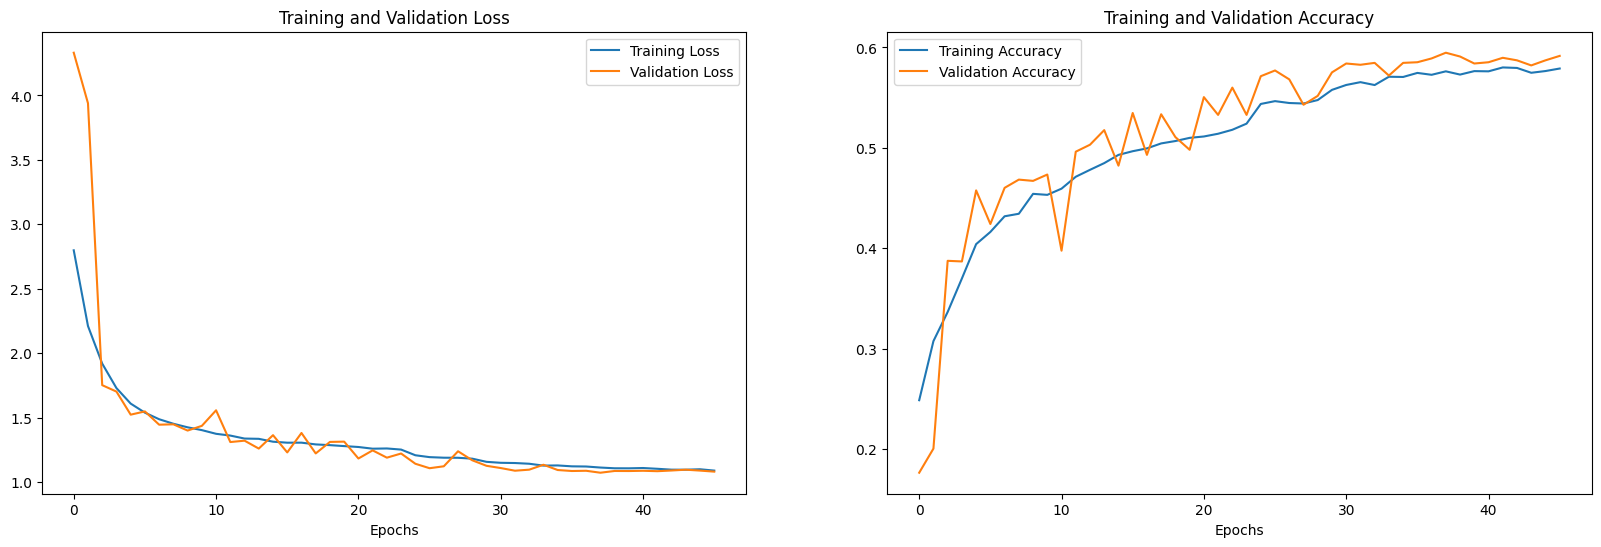

In [ ]:
import matplotlib.pyplot as plt
# Plot Metrics
epochs = range(len(history.history['loss']))

plt.figure(figsize=(20, 6))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.xlabel('Epochs')

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')

plt.show()

50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


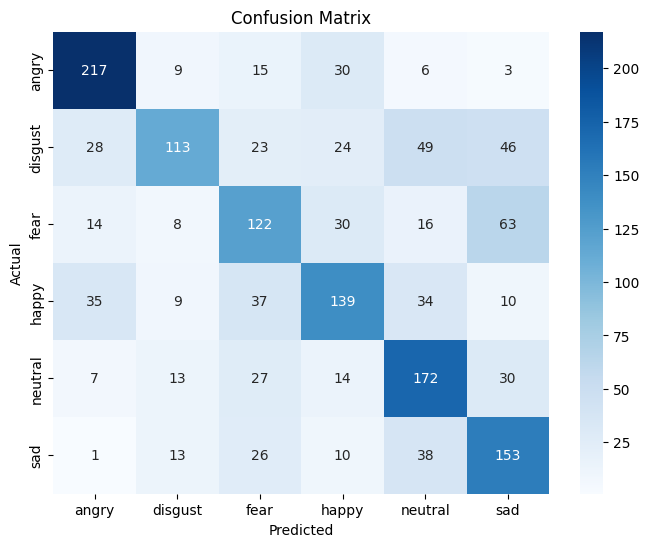

In [ ]:
# prompt: generate confusion metrix for the model for each emotions

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming Y_test and model predictions are available
y_pred = model.predict(X_test_cnn)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(Y_test, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Print classification report

# ... your existing imports ...
from sklearn.metrics import classification_report  # Import classification_report

# Convert y_pred to class labels
y_pred_classes = np.argmax(y_pred, axis=1)  # Get the class with the highest probability

# Convert Y_test to multiclass format (if it's one-hot encoded)
Y_test_classes = np.argmax(Y_test, axis=1)

# Now use y_pred_classes and Y_test_classes in the classification_report
print(classification_report(Y_test_classes, y_pred_classes))

              precision    recall  f1-score   support

           0       0.72      0.78      0.75       280
           1       0.68      0.40      0.50       283
           2       0.49      0.48      0.49       253
           3       0.56      0.53      0.54       264
           4       0.55      0.65      0.60       263
           5       0.50      0.63      0.56       241

    accuracy                           0.58      1584
   macro avg       0.58      0.58      0.57      1584
weighted avg       0.59      0.58      0.57      1584

